# Luke 3D CNN

This notebook contains code for

- syncing with GCS
- preprocessing numpy array data from gs://elvos/numpy
- visualizing the image data
- training models, and
- visualizing model results

## Data Loading

Getting data from GCS, loading it from the local disk

### Arrays

In [ ]:
# Keeps the data in the local filesystem in-sync with GCS
!gsutil rsync -d -r gs://elvos/numpy /home/lzhu7/elvo-analysis/data/numpy

In [5]:
import os
import pathlib
import typing

import numpy as np

In [6]:
def load_data(data_dir: str) -> typing.Dict[str, np.ndarray]:
    """Returns a dictionary which maps patient ids
    to patient pixel data."""
    data_dict = {}
    for filename in os.listdir(data_dir):
        patient_id = filename[:-4] # remove .npy extension
        data_dict[patient_id] = np.load(pathlib.Path(data_dir) / filename)
    return data_dict

In [7]:
data_dict = load_data('/home/lzhu7/elvo-analysis/data/numpy/')

### Labels

In [ ]:
!gsutil cp gs://elvos/labels.csv /home/lzhu7/elvo-analysis/data/labels.csv

In [8]:
import pandas as pd

In [9]:
labels_df = pd.read_csv('/home/lzhu7/elvo-analysis/data/labels.csv',
                        index_col='patient_id')

## Preprocessing: Part I

Removing bad data, duplicates, etc.

In [10]:
def process_images(data: typing.Dict[str, np.ndarray]):
    return {id_: arr for id_, arr in data.items() if len(arr) != 1} # Remove the bad image

In [11]:
data_dict = process_images(data_dict)

In [12]:
def process_labels(labels: pd.DataFrame, data: typing.Dict[str, np.ndarray]):
    # TODO: Remove duplicate HLXOSVDF27JWNCMJ, IYDXJTFVWJEX36DO from ELVO_key
    labels = labels.loc[~labels.index.duplicated()] # Remove duplicate ids
    labels = labels.loc[list(data.keys())]
    assert len(labels) == len(data)
    return labels

In [13]:
labels_df = process_labels(labels_df, data_dict)

## Data Exploration

Simple plotting of (mostly) unprocessed data

For the data in `numpy/`:
- The 6 smallest image heights are: 1, 160, 160, 162, 164, 181.
- The 5 smallest image lengths/widths are: 180, 191, 193, 195, 197.

In [14]:
%matplotlib inline

In [15]:
from matplotlib import pyplot as plt

In [16]:
def plot_images(data: typing.Dict[str, np.ndarray],
                labels: pd.DataFrame,
                num_cols: int,
                limit=20,
                offset=0):
    # Ceiling function of len(data) / num_cols
    num_rows = (min(len(data), limit) + num_cols - 1) // num_cols 
    fig = plt.figure(figsize=(10, 10))
    for i, patient_id in enumerate(data):
        if i < offset:
            continue
        if i >= offset + limit:
            break
        plot_num = i - offset + 1
        ax = fig.add_subplot(num_rows, num_cols, plot_num)
        ax.set_title(f'patient: {patient_id[:4]}...')
        label = 'positive' if labels.loc[patient_id]["label"] else 'negative'
        ax.set_xlabel(f'label: {label}')
        plt.imshow(data[patient_id])
    fig.tight_layout()
    plt.plot()

In [17]:
# Change the transpose input to see different views
# mipped_all = {k:data_dict[k].transpose(0, 2, 1).max(axis=2) for i, k in enumerate(data_dict)}

In [18]:
# os.makedirs('images/', exist_ok=True)
# for i in range((len(data_dict) + 19) // 20):
#     plot_images(mipped_all, labels_df, 5, offset=20 * i)
#     filepath = f'images/{20 * i}-{20 * (i + 1) - 1}.png'
#     plt.savefig(filepath)

## Preprocessing II

Cropping the image, applying mip, etc.

If this takes a long time, save a processed version to disk (share on GCS if it is useful)

In [19]:
import scipy.ndimage

In [20]:
def crop(image3d: np.ndarray, interactive=False) -> np.ndarray:
    """Crops a 3d image in ijk form (height as axis 0).
    """
    assert image3d.shape[1] == image3d.shape[2]
    lw_center = image3d.shape[1] // 2
    lw_min = lw_center - 80
    lw_max = lw_center + 80
    for i in range(len(image3d) - 1, 0, -1):
        if image3d[i, lw_center, lw_center] >= 0:
            height_max = i
            break
    height_min = height_max - 128 # TODO
    return image3d[height_min:height_max, lw_min:lw_max, lw_min:lw_max]


def transpose(image3d: np.ndarray) -> np.ndarray:
    """Move height from the first axis to the last.
    """
    return image3d.transpose(1, 2, 0)


def bound_pixels(image3d: np.ndarray,
                 min_bound: float,
                 max_bound: float) -> np.ndarray:
    image3d[image3d < min_bound] = min_bound
    image3d[image3d > max_bound] = max_bound
    return image3d


def mip(image3d: np.ndarray) -> np.ndarray:
    """Make sure that the array has been transposed first!
    """
    assert image3d.shape[0] == image3d.shape[1]
    return image3d.max(axis=2)


def downsample(image3d: np.ndarray, factor) -> np.ndarray:
    return scipy.ndimage.zoom(image3d, factor)
    

def to_grayscale(image2d: np.ndarray):
    return np.stack([image2d, image2d, image2d], axis=2)


def process_data(data: typing.Dict[str, np.ndarray]) -> typing.Dict[str, np.ndarray]:
    processed = {}
    for id_, arr in data.items():  
        print(f'processing patient {id_}')
        arr = crop(arr)
        arr = transpose(arr)
        arr = downsample(arr, 0.5)
        arr = bound_pixels(arr, -100, 400)
        processed[id_] = arr
    return processed

In [21]:
processed_dirpath = '/home/lzhu7/elvo-analysis/data/luke3/'
if os.path.isdir(processed_dirpath):
    processed_dict = load_data(processed_dirpath)
else:
    processed_dict = process_data(data_dict)

In [ ]:
os.mkdir(processed_dirpath)
arr: np.ndarray
for id_, arr in processed_dict.items():
    np.save(pathlib.Path(processed_dirpath) / f'{id_}.npy', arr)

## Data Validation

Check to see that the data looks right.

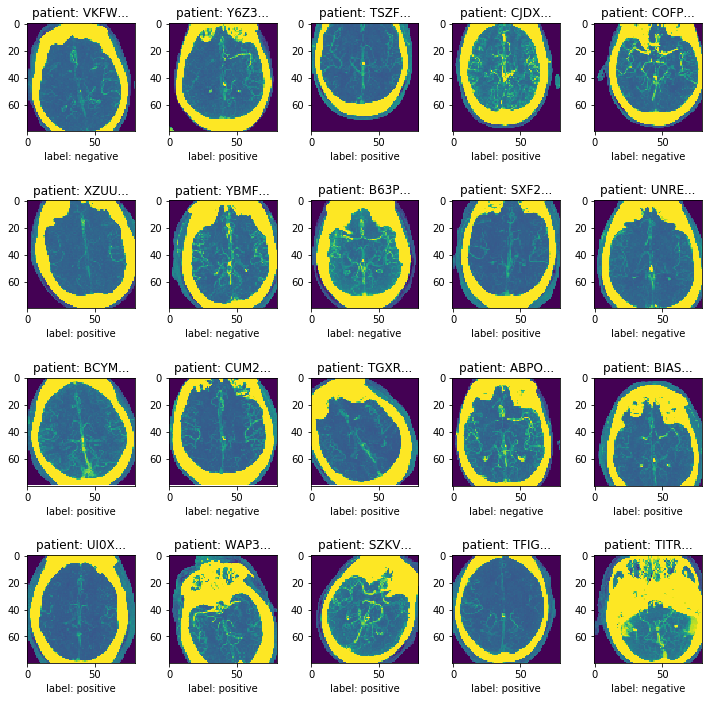

In [22]:
plot_images({k: mip(arr[:, :, 20:40]) for k, arr in processed_dict.items()}, labels_df, 5, offset=180)

## Preprocessing III

Preparations for training (converting from dict/labels to x and y).
Normalization.

In [23]:
import random

In [24]:
def training_data(data: typing.Dict[str, np.ndarray],
                  labels: pd.DataFrame) -> (np.ndarray, np.ndarray):
    shuffled_ids = list(data.keys())
    random.shuffle(shuffled_ids)
    X_list = []
    y_list = []
    for id_ in shuffled_ids:
        X_list.append(data[id_])
        y_list.append(labels.loc[id_])
    return np.stack(X_list), np.stack(y_list)

def one_hot(y):
    y_new = np.zeros((len(y), 2))
    for i in range(len(y)):
        if y[i] < 0.5:
            y_new[i] = np.array([1, 0])
        else:
            y_new[i] = np.array([0, 1])
    return y_new

def normalize(X: np.ndarray) -> np.ndarray:
    return (X - X.mean()) / X.std()

In [25]:
X, y = training_data(processed_dict, labels_df)
# This isn't the best option as we are only supposed to normalize on training mean, not validation mean
X = normalize(X) 
X = np.expand_dims(X, axis=4)
y = one_hot(y)
print(X.shape, y.shape, X.mean(), X.std())

(879, 80, 80, 64, 1) (879, 2) -1.5857622382444641e-18 0.9999999999999927


## Modeling

Model definition and training

In [1]:
from keras import applications
from keras import optimizers
from keras import models, layers, objectives
from keras import backend as K

Using TensorFlow backend.
/gpfs/main/home/lzhu7/elvo-analysis/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [39]:
model = models.Sequential()
model.add(layers.Conv3D(150, 3, padding='same', activation='relu',
                        input_shape=(80, 80, 64, 1)))
model.add(layers.Conv3D(150, 3, padding='same', activation='relu'))
model.add(layers.MaxPool3D(pool_size=(5, 5, 5)))
model.add(layers.Conv3D(150, 3, padding='same', activation='relu'))
model.add(layers.Conv3D(150, 3, padding='same', activation='relu'))
model.add(layers.MaxPool3D(pool_size=(2, 2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(800, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy', sensitivity])

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 80, 80, 64, 150)   4200      
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 80, 80, 64, 150)   607650    
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 16, 16, 12, 150)   0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 16, 16, 12, 150)   607650    
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 16, 16, 12, 150)   607650    
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 8, 6, 150)      0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 57600)             0         
__________

In [41]:
epochs = 5
batch_size = 1

In [ ]:
history = model.fit(X, y,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2)

Train on 703 samples, validate on 176 samples
Epoch 1/5
703/703 [==============================] - 268s - loss: 0.6846 - acc: 0.5932 - sensitivity: 0.5932 - val_loss: 0.6619 - val_acc: 0.6250 - val_sensitivity: 0.6250
Epoch 2/5
703/703 [==============================] - 274s - loss: 0.6747 - acc: 0.6003 - sensitivity: 0.6003 - val_loss: 0.6564 - val_acc: 0.6250 - val_sensitivity: 0.6250
Epoch 3/5
152/703 [=====>........................] - ETA: 200s - loss: 0.6817 - acc: 0.5724 - sensitivity: 0.5724

## Model Evaluation

In [ ]:
# import matplotlib library, and plot training cuve
import matplotlib.pyplot as plt 
plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy') 
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy') 
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history['loss'], 'red', label='Training loss') 
plt.plot(history.history['val_loss'], 'green', label='Validation loss') 
plt.legend()
plt.show()

In [ ]:
# model.save('model-inception-06-15-18-v1.hdf5' )

In [ ]:
def plot_Xy(X, y, i):
    plt.imshow(mip(X[i,:, :, 20:40, 0]))
    plt.title(f'predicted: {model.predict_classes(X[i:i+1])} actual: {y[i, 0]}')

In [ ]:
for i in reversed(range(879)):
    plot_Xy(X, y, i)
    plt.show()
    input()

In [ ]:
y.mean()